In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN

In [9]:
#Importing the CSVs to Dataframe format
UsersDF = pd.read_csv('../raw_data/users_cleaned.csv')
AnimesDF = pd.read_csv('../raw_data/anime_cleaned.csv')
ScoresDF = pd.read_csv('../raw_data/animelists_cleaned.csv')


In [2]:
AnimesDF_cleaned = pd.read_csv('../notebooks/AnimesDF_cleaned.csv')

In [ ]:
# Preprocessing
AnimesDF = AnimesDF.dropna(subset=['genre'])
AnimesDF['producer'] = AnimesDF['producer'].str.split(', ')
AnimesDF['genre'] = AnimesDF['genre'].str.split(', ')

Adding Studio significantly reduce the performance

In [ ]:
# One-hot encoding of the 'studio' column ()
#studio_dummies = pd.get_dummies(AnimesDF['studio'], prefix='studio')

# Concatenating the original dataframe with the new `studio_dummies` dataframe
#AnimesDF = pd.concat([AnimesDF, studio_dummies], axis=1)

# MultiLabelBinarizer for 'genre' column
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(AnimesDF['genre'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=AnimesDF.index)
AnimesDF = pd.concat([AnimesDF, genre_df], axis=1)

# Select and scale features
#studio_columns = [col for col in AnimesDF.columns if 'studio_' in col]
selected_columns = ['score', 'episodes', 'members', 'duration_min'] + list(mlb.classes_) #+ studio_columns
anime_df_selected = AnimesDF[selected_columns].dropna()

In [ ]:
# SCALING AND PRESERVING COLUMNS'NAMES
scaler = StandardScaler().set_output(transform = "pandas")
anime_df_scaled = scaler.fit_transform(anime_df_selected)
display(anime_df_scaled)


In [3]:
anime_df_scaled = AnimesDF_cleaned

# PCA'ING AND PRESERVING COLUMNS'NAMES
threhsold_pca = 25
pca = PCA(n_components=threhsold_pca, whiten=True).set_output(transform="pandas") # find all the Principal Components PC (no y!)
pca.fit(anime_df_scaled)
features_pca = pca.transform(anime_df_scaled)

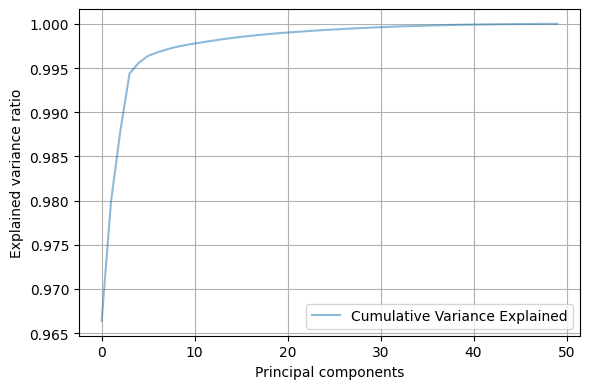

In [4]:
# Apply PCA
pca = PCA().set_output(transform = "pandas")
features_pca = pca.fit_transform(anime_df_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(range(len(explained_variance)), np.cumsum(explained_variance), alpha=0.5, label='Cumulative Variance Explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

In [5]:
# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['k', 'Silhouette Score', 'Calinski Harabasz Score', 'Davies Bouldin Score'])

# Initialize the best score and corresponding k value
best_score = -1
best_k = -1

# Loop over the range of k values
for k in range(2, 50):  # we start from 2 because silhouette_score is not defined for a single cluster
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto')
    clusters = kmeans.fit_predict(features_pca)

    silhouette = silhouette_score(features_pca, clusters)
    calinski_harabasz = calinski_harabasz_score(features_pca, clusters)
    davies_bouldin = davies_bouldin_score(features_pca, clusters)
    
    # Update the best score and corresponding k value if current score is better
    if calinski_harabasz > best_score:
        best_score = calinski_harabasz
        best_k = k

    new_row = pd.DataFrame({'k': k, 'Silhouette Score': silhouette, 'Calinski Harabasz Score': calinski_harabasz, 'Davies Bouldin Score': davies_bouldin}, index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

# Display the results
print(results)
print("Best k value:", best_k)

# Fit the KMeans model with the best k value
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init = 'auto')
cluster_kmeans = kmeans.fit_predict(features_pca)


     k  Silhouette Score  Calinski Harabasz Score  Davies Bouldin Score
0    2          0.957584              9801.667303              0.431998
1    3          0.900557             11669.121895              0.511409
2    4          0.887732             14239.300611              0.483657
3    5          0.812946             15546.027731              0.520998
4    6          0.719790             13910.174241              0.565142
5    7          0.688361             15821.504813              0.599779
6    8          0.717889             16073.798560              0.493555
7    9          0.596526             16786.708008              0.548535
8   10          0.500487             16638.293060              0.602325
9   11          0.494123             15920.964702              0.625824
10  12          0.494231             16476.370839              0.607026
11  13          0.494163             16051.267509              0.563174
12  14          0.480653             15438.012393              0

In [ ]:
# Apply Elbow method
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto')
    kmeanModel.fit(features_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### DBScan Implementation ###

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=17)
clusters = dbscan.fit_predict(features_pca)

# Add clusters to the DataFrame
AnimesDF['cluster_dbscan'] = clusters

# Check the number of animes in each cluster
print(AnimesDF['cluster_dbscan'].value_counts())

# Check the mean values of the features in each cluster
print(AnimesDF.groupby('cluster_dbscan')[['episodes', 'score', 'members', 'duration_min']].mean())


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Define the range of values to test
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(5, 20)

best_score = -1  # Initialize the best score

# Perform the parameter grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features_pca)
        
        # Evaluate the clustering performance
        # You can use metrics like silhouette score, Calinski-Harabasz score, or Davies-Bouldin score
        
        # Calculate the evaluation metric for the current parameter values
        #silhouette = silhouette_score(features_pca, clusters)
        calinski_harabasz = calinski_harabasz_score(features_pca, clusters)
        #davies_bouldin = davies_bouldin_score(features_pca, clusters)
        
        # Choose the evaluation metric that suits your problem and data
        
        # Update the best score and parameter values if the current score is higher
        evaluation_metric = calinski_harabasz
        if evaluation_metric > best_score:
            best_score = evaluation_metric
            best_eps = eps
            best_min_samples = min_samples

# After the nested loops, you can print the best parameter values and the corresponding score
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best score:", best_score)


In [ ]:
import plotly.express as px

# Perform t-SNE
tsne = TSNE(n_components=3)
features_tsne = tsne.fit_transform(features_pca)

# Create a DataFrame with the t-SNE features and the clusters
tsne_df = pd.DataFrame(data={'x': features_tsne[:, 0], 'y': features_tsne[:, 1], 'z': features_tsne[:, 2], 'cluster_kmeans': AnimesDF_cleaned['cluster_kmeans'], 'cluster_dbscan': AnimesDF_cleaned['cluster_dbscan']})

# Create an interactive 3D scatter plot for the KMeans clusters
fig_kmeans = px.scatter_3d(tsne_df, x='x', y='y', z='z', color='cluster_kmeans')
fig_kmeans.update_layout(title='KMeans Clusters')

# Create an interactive 3D scatter plot for the DBSCAN clusters
#seguimi fig_dbscan = px.scatter_3d(tsne_df, x='x', y='y', z='z', color='cluster_dbscan')
#fig_dbscan.update_layout(title='DBSCAN Clusters')

# Display the interactive plots
fig_kmeans.show()
#fig_dbscan.show()

# Add GMM clusters to the DataFrame
tsne_df['cluster_gmm'] = AnimesDF['cluster_gmm']

# Create an interactive 3D scatter plot for the GMM clusters
fig_gmm = px.scatter_3d(tsne_df, x='x', y='y', z='z', color='cluster_gmm')
fig_gmm.update_layout(title='GMM Clusters')

# Display the interactive plot
fig_gmm.show()


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score

# List to store the average Calinski Harabasz scores for each number of components
scores = []

# Define the range of the number of components to search
n_components_range = range(2, 50)

# Perform a grid search manually using a for loop
for n_components in n_components_range:
    # Create and fit a GaussianMixture model with the current number of components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(features_pca)
    
    # Predict the cluster for each data point
    clusters = gmm.predict(features_pca)
    
    # Compute the Calinski Harabasz score
    score = calinski_harabasz_score(features_pca, clusters)
    
    # Append the score to the scores list
    scores.append(score)

# Find the number of components that gives the highest score
best_n_components = n_components_range[np.argmax(scores)]

print(f"Best number of components: {best_n_components}")


Best number of components: 2


In [ ]:
pd.Series(scores).describe()

Best number of components: 39

In [16]:
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(features_pca)

# Predict the cluster for each data point
clusters_gmm = gmm.predict(features_pca)

# Add clusters to the DataFrame
AnimesDF_cleaned['cluster_gmm'] = clusters_gmm

# Check the number of animes in each cluster
print(AnimesDF_cleaned['cluster_gmm'].value_counts())

# Check the mean values of the features in each cluster
#print(AnimesDF_cleaned.groupby('cluster_gmm')[['episodes', 'score', 'members', 'duration_min']].mean())


0    5783
1      44
Name: cluster_gmm, dtype: int64


KeyError: 'PC1'

In [14]:
AnimesDF_cleaned['cluster_kmeans'] = cluster_kmeans